# Now the fun begins!

## Plan for Data Exploration step:

- Explore Timeline Data.
- Decide Which way to summarise timeline data (i.e. perform feature engineering) such that it can be merged to Summaries data.
- Make some visualisations along the way

## Modelling step:

- Combine the two datasets with one row being one player per game.

- Perform Clustering to see if data can be split in this way

- Build a classification model using prepared data.
- Validate model(s) & perform some tuning (use metrics such as ROC curve for this)

- Depending on time constraints, pick the best performant model & params to take to production.

## Production step (not done in notebooks):

- The production solution will be a model with returns a 'pro-likeness' score. (between 0-1.) The higher the score, the more pro-like the player is. As such one may call the model on any player (limited to the set of players in this dataset) and a pro-likeness score will be returned. The model can be called on amateur players, and the higher the score, the more likely this player will be a good fit for pro-play!

# Very brief explanation of League of legends

Since we are about to start exploring the data, and the context of the data has not yet been described, I'll put a section here for it: (We covered this in the slides too but since it is very relevant here it is repeated, with a slightly larger focus on the data)

The game we have collected data on is called League of Legends. The game goes as follows:

- Players play on a map. The map in League of Legends is denoted by a 16,000 x 16,000 grid. 
- One team starts from the bottom left corner (0,0), the other in the top right (16,000, 16,000). 
- The game is essentially a team- tower defence game, with the winner destroying the enemy teams inner most tower. 
- Teams play in groups of 5, so there are 10 players in total, each controlling one champion, whose job it is to destroy the inner most tower. 
- They can also kill each other if this helps to meet the main objective, and they can 'farm' - i.e. kill neutral monsters around the map to earn gold and experience. 

With that out of the way let's see what we find!

## This is what the map looks like:

In [299]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from scipy.stats import ks_2samp

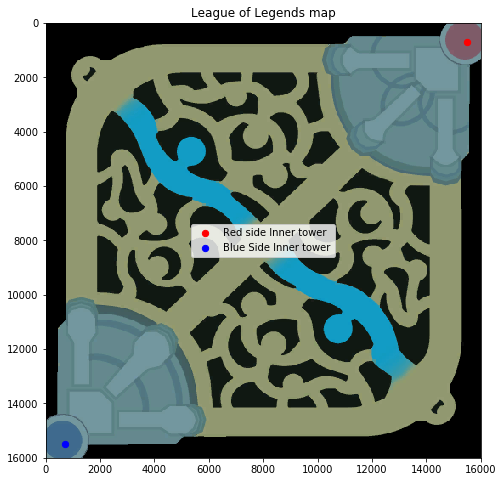

In [65]:
plt.figure(figsize=(8,8))

img = Image.open('minimap.png')
img = img.resize((16000,16000)) # resize to fit with riot games coordinates

plt.imshow(img)

# put a red dot, size 40, at 2 locations:
plt.scatter(x=[15500], y=[700], c='r', s=40, label='Red side Inner tower')
plt.scatter(x=[700], y=[15500], c='b', s=40, label='Blue Side Inner tower')

plt.title('League of Legends map')
plt.legend(loc='center')

plt.show()

### Start by exploring the timeline data. 

Our plan for this dataset will be to create extra summary statistics that are not present in the summaries dataset. So let's explore it to see what we can get!

The interesting thing about this data is that we have **location information**. This is not present in summary data so we should make use of it.


In [3]:
timeline = pd.read_csv('./match-data/parsed-timelines/timeline.csv')

In [4]:
timeline.head()

,id,matchId,name,puuid,timestamp,type,x,y,pro_flag
0,ICOQpQtAgQSCxIHYwA2jQhKDhGkDvteAuuFsmFWgqSrEI4A,EUW1_5523905698,Showkz,1zzOOoelGehgEFF0OVlbxGpnGuoIZITylM8kKQKoTgtrDj...,191580,CHAMPION_KILL,4198,12688,0
1,ICOQpQtAgQSCxIHYwA2jQhKDhGkDvteAuuFsmFWgqSrEI4A,EUW1_5523905698,Showkz,1zzOOoelGehgEFF0OVlbxGpnGuoIZITylM8kKQKoTgtrDj...,191580,CHAMPION_SPECIAL_KILL,4153,12062,0
2,ICOQpQtAgQSCxIHYwA2jQhKDhGkDvteAuuFsmFWgqSrEI4A,EUW1_5523905698,Showkz,1zzOOoelGehgEFF0OVlbxGpnGuoIZITylM8kKQKoTgtrDj...,195478,CHAMPION_KILL,4701,14048,0
3,ICOQpQtAgQSCxIHYwA2jQhKDhGkDvteAuuFsmFWgqSrEI4A,EUW1_5523905698,Showkz,1zzOOoelGehgEFF0OVlbxGpnGuoIZITylM8kKQKoTgtrDj...,195478,CHAMPION_SPECIAL_KILL,4680,14007,0
4,ICOQpQtAgQSCxIHYwA2jQhKDhGkDvteAuuFsmFWgqSrEI4A,EUW1_5523905698,Showkz,1zzOOoelGehgEFF0OVlbxGpnGuoIZITylM8kKQKoTgtrDj...,290086,CHAMPION_DEATH,1768,12875,0


In [92]:
# let's plot building kills so we can see visually where these happen - 
# we can add in the average time in each game a structure is destroyed by grouping on x,y and taking avg of timestamp

turret_kills = timeline.loc[timeline['type'] == 'BUILDING_KILL'].groupby(['x',
                                                                          'y'])[['timestamp']].agg(['mean', 'count']).reset_index()

turret_kills['time_min'] = np.floor(turret_kills['timestamp']['mean'] / 1000 / 60)

Here we see this beautiful image both teams working their way from the outer most to the inner most towers


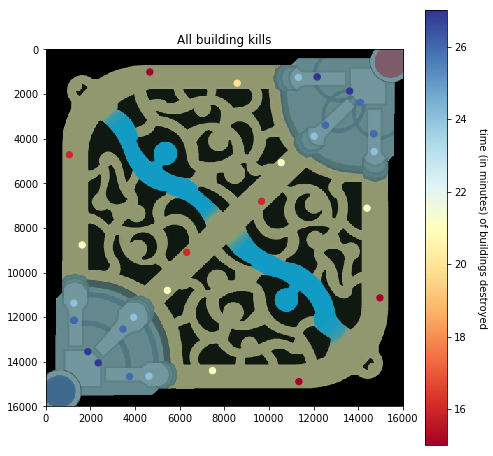

In [91]:
scale_factor = 1.08 # it seems we have to scale the data to be inline with our image

print('Here we see this beautiful image both teams working their way from the outer most to the inner most towers')

plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu')

img = Image.open('minimap.png')
img = img.resize((16000,16000))

plt.imshow(img)


sc = plt.scatter(x=turret_kills['x']*scale_factor, y = 16000 - (turret_kills['y']*scale_factor), c=turret_kills['time_min'], s=40, cmap = cm)

#sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('time (in minutes) of buildings destroyed', rotation=270, labelpad = 20)

plt.title('All building kills')

plt.show()


In [ ]:
# Let's try do the same with kills - though they can't be grouped in the same way. 
# So let's make a heatmap instead, with the colour being the time

This map shows largely the same story through a different channel; As the game progresses, events happen closer to the inner towers of both sides


/Users/natalia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


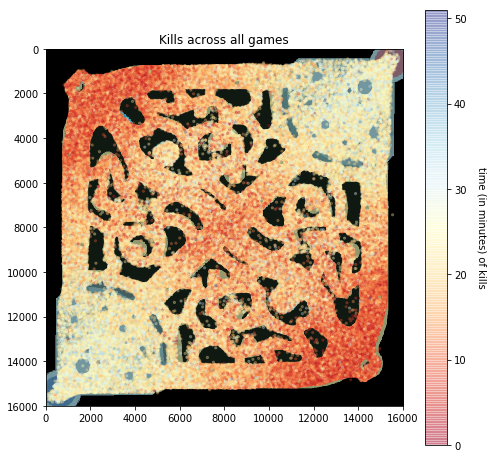

In [115]:
print('This map shows largely the same story through a different channel; As the game progresses, events happen closer to the inner towers of both sides')

kills = timeline.loc[timeline['type'].isin(['CHAMPION_KILL'])]
kills['time_min'] = np.floor(kills['timestamp'] / 1000 / 60)
scale_factor = 1.08

plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('RdYlBu')

img = Image.open('minimap.png')
img = img.resize((16000,16000))

plt.imshow(img)
sc = plt.scatter(x=kills['x']*scale_factor, 
                 y = 16000 - (kills['y']*scale_factor), 
                 s=5, 
                 alpha=0.3, 
                 c=kills['time_min'],
                 cmap = cm)

cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('time (in minutes) of kills', rotation=270, labelpad = 20)

plt.title('Kills across all games')

plt.show()

### Let's look at any early indicators average behaviour differences between pros and amateurs

For turrets we can construct a residual in the building kills relatively easily; since we can groupby location

In [286]:
######## NOTE TO ASSESSORS: I DIDN'T WRITE THIS FUNCTION I FOUND IT ON STACKOVERFLOW ###################

# it is used to shift the center of a colorbar to be able to read plots easier

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

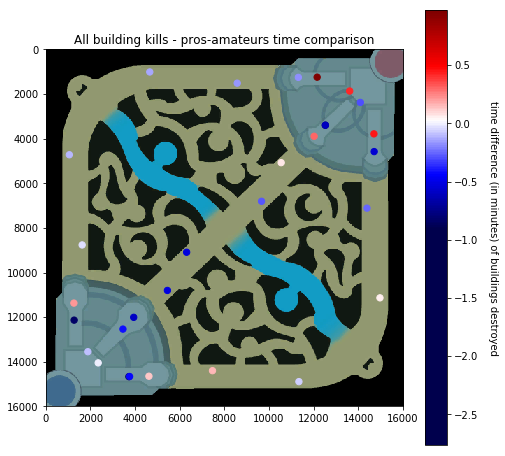

In [305]:


turret_kills_pros = timeline.loc[(timeline['type'] == 'BUILDING_KILL') &
                                (timeline['pro_flag'] == 1)].groupby(['x','y'])[['timestamp']].agg(['mean', 'count']).reset_index()

turret_kills_pros['time_min'] = turret_kills_pros['timestamp']['mean'] / 1000 / 60
turret_kills_pros['count'] = turret_kills_pros['timestamp']['count']

turret_kills_amateurs = timeline.loc[(timeline['type'] == 'BUILDING_KILL') &
                                (timeline['pro_flag'] == 0)].groupby(['x','y'])[['timestamp']].agg(['mean', 'count']).reset_index()

turret_kills_amateurs['time_min'] = turret_kills_amateurs['timestamp']['mean'] / 1000 / 60
turret_kills_amateurs['count'] = turret_kills_amateurs['timestamp']['count']

# [['x','y','time_min', 'count']]
merged = pd.merge(turret_kills_pros[['x','y','time_min', 'count']], 
                  turret_kills_amateurs[['x','y','time_min', 'count']],
                  on=['x','y'], suffixes=('_pros', '_amateurs'))

merged['residual'] = merged['time_min_pros'] - merged['time_min_amateurs']

# data cleaning - there are a few groups with very few counts - remove these
merged = merged.loc[merged['count_pros'] > 5].reset_index(drop=True)

scale_factor = 1.08 # it seems we have to scale the data to be inline with our image
#print('Here we see this beautiful image both teams working their way from the outer most to the inner most towers')

plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('seismic')

cm_shift = shiftedColorMap(cm, start=-3, midpoint=0.0, stop=1.0, name='shiftedcmap')

img = Image.open('minimap.png')
img = img.resize((16000,16000))

plt.imshow(img)


sc = plt.scatter(x=merged['x']*scale_factor, y = 16000 - (merged['y']*scale_factor), c=merged['residual'], s=40, cmap = cm_shift)

#sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('time difference (in minutes) of buildings destroyed', rotation=270, labelpad = 20)

plt.title('All building kills - pros-amateurs time comparison')

plt.show()

This is interesting. It shows that professionals destroy towers considerably earlier than amateurs, especially in the mid lane. (The central diagonal)

As such this is an identifier of a professional player. We can construct a summary feature (later) to reflect this - simply the average time of all building kills. We would do better to construct average time of specific towers, but this would take too long

## We found a feature!

In [304]:
pro_all_turret_kills = timeline.loc[(timeline['type'] == 'BUILDING_KILL') &
                                (timeline['pro_flag'] == 1)]
amateur_all_turret_kills = timeline.loc[(timeline['type'] == 'BUILDING_KILL') &
                                (timeline['pro_flag'] == 0)]

total_building_kill_diff = (pro_all_turret_kills['timestamp'].mean() - amateur_all_turret_kills['timestamp'].mean()) / 1000 / 60

pvalue = ks_2samp(list(pro_all_turret_kills['timestamp'].values), list(amateur_all_turret_kills['timestamp'].values))

print(f'pvalue is {np.round(pvalue[1],7)}, these distributions are different, with a mean difference of {np.round(total_building_kill_diff, 2)} minutes')

pvalue is 5e-07, these distributions are different, with a mean difference of -0.44 minutes


Can we do the same with kills/ deaths? We would need to construct a heatmap to compare individual points directly

let's downselect the non-pros to get a comparison of the distributions on the same scale


<Figure size 576x576 with 0 Axes>

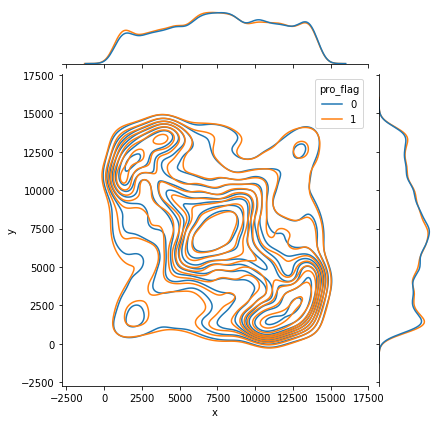

In [25]:


kills = timeline.loc[timeline['type'].isin(['CHAMPION_KILL'])]

kills_pros = kills.loc[kills['pro_flag'] == 1]
kills_amateurs = kills.loc[kills['pro_flag'] == 0].sample(frac = 0.13) # ratio was computed for this fraction
kills = kills_pros.append(kills_amateurs).reset_index(drop=True)
kills['time_min'] = np.floor(kills['timestamp'] / 1000 / 60)
scale_factor = 1.08



plt.figure(figsize=(8,8))

kills['pro_flag_str'] = kills['pro_flag'].astype(str)
sn.jointplot(data=kills, x="x", y="y", hue=kills["pro_flag"], kind='kde')
p.fig.suptitle("Locations of kills between pros and amateurs")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.show()

It looks like the kills happen in very similar places... let's try the same with deaths

Can we do the same with kills? We would need to construct a heatmap to compare individual points directly

Let's downselect the non-pros to get a comparison of the distributions on the same scale



<Figure size 576x576 with 0 Axes>

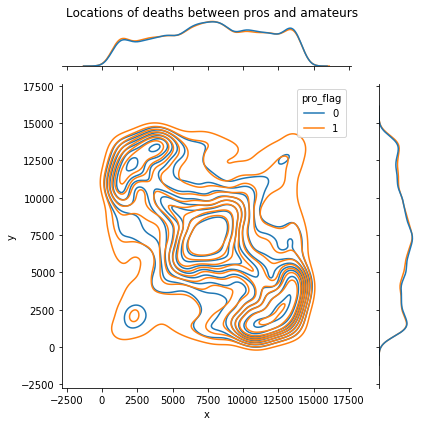

In [24]:
deaths = timeline.loc[timeline['type'].isin(['CHAMPION_DEATH'])]

deaths_pros = deaths.loc[deaths['pro_flag'] == 1]
deaths_amateurs = deaths.loc[deaths['pro_flag'] == 0].sample(frac = 0.128) # ratio was computed for this fraction
deaths = deaths_pros.append(deaths_amateurs).reset_index(drop=True)
deaths['time_min'] = np.floor(deaths['timestamp'] / 1000 / 60)
scale_factor = 1.08


plt.figure(figsize=(8,8))
p = sn.jointplot(data=deaths, x="x", y="y", hue=deaths["pro_flag"], kind='kde')
p.fig.suptitle("Locations of deaths between pros and amateurs")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.show()

Let's look at champion_special_kill. This defines where the first kill of the game happens

<Figure size 576x576 with 0 Axes>

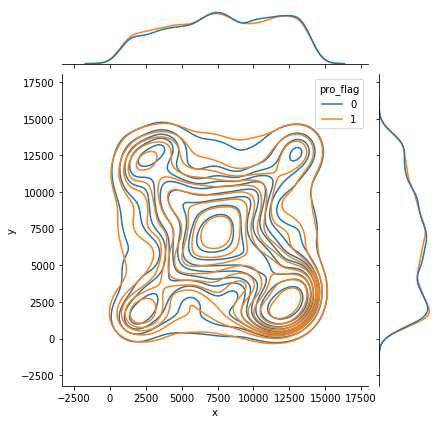

In [311]:

special_kills = timeline.loc[timeline['type'].isin(['CHAMPION_SPECIAL_KILL'])]

special_kills_pros = special_kills.loc[special_kills['pro_flag'] == 1]
special_kills_amateurs = special_kills.loc[special_kills['pro_flag'] == 0].sample(frac = 0.13) # ratio was computed for this fraction
special_kills = special_kills_pros.append(special_kills_amateurs).reset_index(drop=True)
special_kills['time_min'] = np.floor(special_kills['timestamp'] / 1000 / 60)
scale_factor = 1.08



plt.figure(figsize=(8,8))

kills['pro_flag_str'] = kills['pro_flag'].astype(str)
sn.jointplot(data=kills, x="x", y="y", hue=kills["pro_flag"], kind='kde')
p.fig.suptitle("Locations of kills between pros and amateurs")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.show()

Interestingly the deaths and champion special kills also show very similar distributions. The special kills won't be much more use to us in events data compared to summary data, since there's only 1 per game and recorded in summary stats anyway!

Perhaps then it is not enough to know -where- a champion died/was killed, they seem to be very similar. Another useful thing to note is that the ratio between pro players/amateur for both kills and deaths is almost exactly the same (0.13) meaning they seem to get kills and die in the same proportions.

Let's try to incorporate the time at which they died, to see if there is a meaningful difference here.

To do this, we will need to group kills into 'tiles' on the map. Since every kill can happen on a unique pixel, we'll need to tile to make residuals



In [57]:
# the easiest way I thought of doing this was to simply round our x, y values to the nearest 50, then plot them. 
# This reduces the complexity of understanding whether a point was within a certain bounding box

kills_pros = kills.loc[kills['pro_flag'] == 1].reset_index(drop=True)
kills_pros['x_tiled'] = np.round(kills_pros['x'], -3)
kills_pros['y_tiled'] = np.round(kills_pros['y'], -3)
kills_pros_tiled = kills_pros.groupby(['x_tiled', 'y_tiled'])[['time_min']].agg({'count', 'mean'}).reset_index()

kills_amateur = kills.loc[kills['pro_flag'] == 0].reset_index(drop=True)
kills_amateur['x_tiled'] = np.round(kills_amateur['x'], -3)
kills_amateur['y_tiled'] = np.round(kills_amateur['y'], -3)
kills_amateur_tiled = kills_amateur.groupby(['x_tiled', 'y_tiled'])[['time_min']].agg({'count', 'mean'}).reset_index()

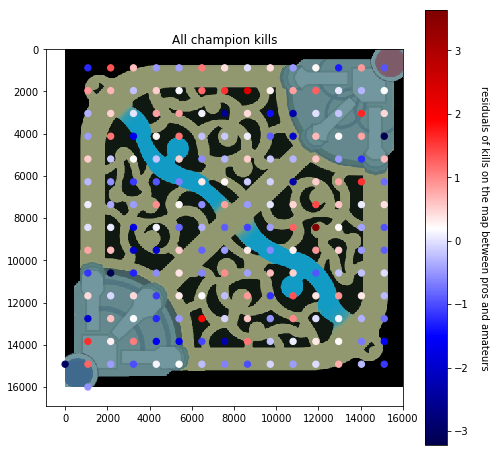

In [80]:
# we have an issue in that we want to look at differences between players - but don't have certain tiles for the pros.
# in this case we can't make a comparison so we should remove them.

kills_merged = pd.merge(kills_pros_tiled, kills_amateur_tiled, 
         on=['x_tiled', 'y_tiled'], 
         how='inner', suffixes=('_pros', '_amateurs'))

kills_merged['time_residual'] = kills_merged['time_min_pros']['mean'] - kills_merged['time_min_amateurs']['mean']

kills_merged['pro_count_normalised'] = kills_merged['time_min_pros']['count'] / kills_merged['time_min_pros']['count'].sum()
kills_merged['amateur_count_normalised'] = kills_merged['time_min_amateurs']['count'] / kills_merged['time_min_amateurs']['count'].sum()
kills_merged['activity_residual'] = kills_merged['pro_count_normalised'] - kills_merged['amateur_count_normalised']

# there was a single -12.5 value skewing the colours - let's remove
kills_merged = kills_merged.loc[(kills_merged['time_min_amateurs']['count'] >=10) & 
                               ((kills_merged['time_residual'] >= 0.5) | (kills_merged['time_residual'] <= 0.5))]

plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('seismic')

img = Image.open('minimap.png')
img = img.resize((16000,16000))

plt.imshow(img)

sc = plt.scatter(x=kills_merged['x_tiled']*scale_factor, y = 16000 - (kills_merged['y_tiled']*scale_factor), c=kills_merged['time_residual'], s=40, cmap = cm)

#sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('residuals of kills on the map between pros and amateurs', rotation=270, labelpad = 20)

plt.title('All champion kills')

plt.show()

A qualitative view shows that pros on average appear to be getting kills earlier on the map than amateurs. Let's try to plot the same for deaths and see if we get the reverse result. A quick average shows that pros generally get kills ~1/20th a minute faster than amateurs across the board. Not a huge result!

In [186]:
location_weighted_average = kills_merged['time_residual'].mean()

print(f'mean of differences (which are already an aggregate figure) is {np.round(location_weighted_average, 2)} minutes. Not a huge amount.')
print(f'when we compare this to the total mean, that figure is 0.06 minutes, a small (but positive) amount. \n This indicates that pros kill players earlier in uncommon parts of the map - lets explore this idea')


mean of differences (which are already an aggregate figure) is -0.08 minutes. Not a huge amount.
when we compare this to the total mean, that figure is 0.06 minutes, a small (but positive) amount. 
 This indicates that pros kill players earlier in uncommon parts of the map - lets explore this idea


Let's narrow in on differenet regions of the map and see if the pros behave differently to the amateurs here.


In [183]:
timeline_base = timeline.loc[(timeline['y'] <= 3000/1.08) & 
                            (timeline['x'] >= 5000/1.08)]

amateur_base = timeline_base.loc[(timeline['type'] == 'CHAMPION_DEATH') & (timeline_base['pro_flag'] == 0)]
pro_base = timeline_base.loc[(timeline['type'] == 'CHAMPION_DEATH') & (timeline_base['pro_flag'] == 1)]

difference =  (pro_base['timestamp'].mean() - amateur_base['timestamp'].mean()) / 1000 / 60

pvalue = ztest(pro_base[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'], 
      amateur_base[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'])[1]


print(f'difference of {difference} minutes with a pvalue of {pvalue}')

difference of 0.24553164865273672 minutes with a pvalue of 0.7480499566217804


Having viewed a few different areas, not many of them appear to give statistically significant results (pvalues generally ~0.75) with a difference of anything much more than 0.2 mins (12 seconds) which, would be a bit of a stretch to call a useful feature. Interesting analysis though! Perhaps with a larger dataset we would get different results. Sadly I don't think I'll be using any kills/time/location features!

**Let's try the same analysis for deaths**

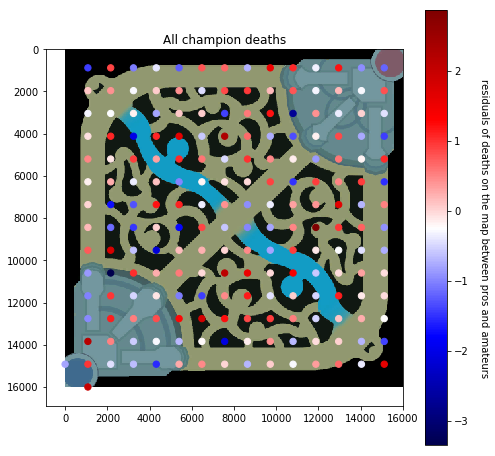

In [81]:
deaths_pros = deaths.loc[deaths['pro_flag'] == 1].reset_index(drop=True)
deaths_pros['x_tiled'] = np.round(deaths_pros['x'], -3)
deaths_pros['y_tiled'] = np.round(deaths_pros['y'], -3)
deaths_pros_tiled = deaths_pros.groupby(['x_tiled', 'y_tiled'])[['time_min']].agg({'count', 'mean'}).reset_index()

deaths_amateur = kills.loc[kills['pro_flag'] == 0].reset_index(drop=True)
deaths_amateur['x_tiled'] = np.round(deaths_amateur['x'], -3)
deaths_amateur['y_tiled'] = np.round(deaths_amateur['y'], -3)
deaths_amateur_tiled = deaths_amateur.groupby(['x_tiled', 'y_tiled'])[['time_min']].agg({'count', 'mean'}).reset_index()

# we have an issue in that we want to look at differences between players - but don't have certain tiles for the pros.
# in this case we can't make a comparison so we should remove them.

deaths_merged = pd.merge(deaths_pros_tiled, deaths_amateur_tiled, 
         on=['x_tiled', 'y_tiled'], 
         how='inner', suffixes=('_pros', '_amateurs'))

deaths_merged['time_residual'] = deaths_merged['time_min_pros']['mean'] - deaths_merged['time_min_amateurs']['mean']

deaths_merged['pro_count_normalised'] = deaths_merged['time_min_pros']['count'] / deaths_merged['time_min_pros']['count'].sum()
deaths_merged['amateur_count_normalised'] = deaths_merged['time_min_amateurs']['count'] / deaths_merged['time_min_amateurs']['count'].sum()
deaths_merged['activity_residual'] = deaths_merged['pro_count_normalised'] - deaths_merged['amateur_count_normalised']

# there was a single -12.5 value skewing the colours - let's remove
deaths_merged = deaths_merged.loc[(deaths_merged['time_min_amateurs']['count'] >=10) & 
                               ((deaths_merged['time_residual'] >= 0.5) | (deaths_merged['time_residual'] <= 0.5))]

plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('seismic')

img = Image.open('minimap.png')
img = img.resize((16000,16000))

plt.imshow(img)

sc = plt.scatter(x=deaths_merged['x_tiled']*scale_factor, y = 16000 - (deaths_merged['y_tiled']*scale_factor), c=deaths_merged['time_residual'], s=40, cmap = cm)

#sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('residuals of deaths on the map between pros and amateurs', rotation=270, labelpad = 20)

plt.title('All champion deaths')

plt.show()


Now it appears that red dominates - i.e., pros are dying later than amateurs. We can turn this into a feature too

Let's check what the global (position-normalised) average says for number of minutes difference

In [82]:
deaths_merged['time_residual'].mean()

0.03778821846724333

A curious observation: Comparing the two graphs visually (kills/deaths) it appears reasonably obvious there is a difference, yet the global average shows a very small difference (about 2 seconds). 

This makes me wonder, is this just statistical noise? Let's check the distribution and do the appropriate test across these two distributions to see if there is a difference or not

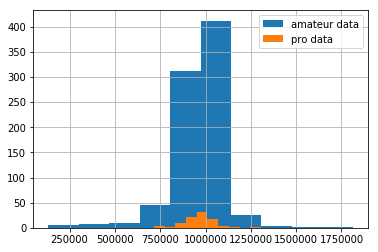

In [159]:
amateur = timeline.loc[(timeline['type'] == 'CHAMPION_KILL') & (timeline['pro_flag'] == 0)]
pro = timeline.loc[(timeline['type'] == 'CHAMPION_KILL') & (timeline['pro_flag'] == 1)]


amateur[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'].hist(label='amateur data')
pro[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'].hist(label='pro data')
plt.legend()
plt.show()




In [117]:
from statsmodels.stats.weightstats import ztest

pvalue = ztest(amateur[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'], 
      pro[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'])[1]

print(f'pvalue that kills between pros and amateurs on average is the same is {np.round(pvalue,2)}, i.e. not statistically significant')

pvalue that kills between pros and amateurs on average is the same is 0.96, i.e. not statistically significant


On average it appears our two datasets are not statistically significant

In league of legends the game is divided into sections - the bottom right section with the greenery is known as the 'bottom side jungle' - and all values here appear to be reasonably red. If we filter all our pros and amateurs by this triangle, would the deaths be meaningfully different? 

We can reasonably easily filter these values by making two squares; one to represent the bottom left and bottom right side of the jungle. The coordinates would be:

| rectangle 1: |
| ------ |
| x > 5000/1.08 |
| x < 11000/1.08 |
| y > 2000/1.08 |
|y < 5000/1.08 |

| rectangle 2: |
| ----- |
| x < 14000/1.08 |
| x > 11000/1.08 |
| y > 5000/1.08 |
| y < 11000 / 1.08 |

bear in mind these are very rough!

We can take our timeline data, filter by these, and do another z-test

In [152]:
timeline_jungle = timeline.loc[((timeline['x'] > 5000/1.08) & 
                              (timeline['x'] < 11000/1.08) & 
                              (timeline['y'] > 2000/1.08) & 
                              (timeline['y'] < 5000/1.08)) |
                              ((timeline['x'] < 14000/1.08) & 
                              (timeline['x'] > 11000/1.08) & 
                              (timeline['y'] > 5000/1.08) & 
                              (timeline['y'] < 11000/1.08))]

amateur_jungle = timeline_jungle.loc[(timeline_jungle['type'] == 'CHAMPION_DEATH') & (timeline_jungle['pro_flag'] == 0)]
pro_jungle = timeline_jungle.loc[(timeline_jungle['type'] == 'CHAMPION_DEATH') & (timeline_jungle['pro_flag'] == 1)]


In [153]:
pvalue = ztest(amateur_jungle[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'], 
      pro_jungle[['id','timestamp']].groupby('id').mean().reset_index()['timestamp'])[1]

print(f'pvalue has a value of {np.round(pvalue,2)} for our "bottom jungle" filter')

pvalue has a value of 0.51 for our "bottom jungle" filter


In [160]:
difference =  (pro_jungle['timestamp'].mean() - amateur_jungle['timestamp'].mean()) / 1000 / 60

print(f'the mean difference between the two datasets is {np.round(difference, 2)} minutes')

the mean difference between the two datasets is 0.49 minutes




With a p-value of 0.5 it's not the most convincing for a test, but the difference is half a minute! With a larger test size I am confident this would become statistically significant. Let's therefore use this as a feature for our clustering / classification where available. 

# We found a new feature!

**The feature will be: average time (per game per player) of all deaths in the bottom jungle**

Let's see if we can spot any simpler differences in the datasets that don't require so much parsing

In [188]:
# let's see if activity per game is materially different between pros and amateurs

pros = timeline.loc[timeline['pro_flag'] == 1]
amateurs = timeline.loc[timeline['pro_flag'] == 0]

In [204]:
pros.groupby(['matchId', 'id'])['timestamp'].count().mean()

13.5219086520609

In [205]:
amateurs.groupby(['matchId', 'id'])['timestamp'].count().mean()

13.119858139480623

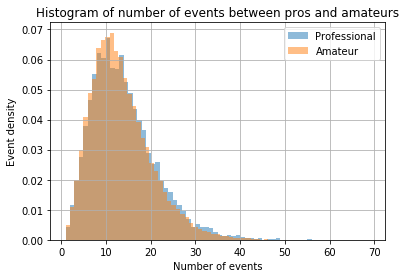

In [255]:
# bins chosen to be the range of number of events each distribution has
pros.groupby(['matchId', 'id'])['timestamp'].count().hist(alpha=0.5, density=True, label='Professional', bins=55)
amateurs.groupby(['matchId', 'id'])['timestamp'].count().hist(alpha=0.5, density=True, label='Amateur', bins=69)
plt.legend()
plt.xlabel('Number of events')
plt.ylabel('Event density')
plt.title('Histogram of number of events between pros and amateurs')
plt.show()

In [266]:
# This looks very similar.. How does it score on a significance test? Since my data is skewed let's use a ks test

pros_values = pros.groupby(['matchId', 'id'])[['timestamp']].count()
amateur_values = amateurs.groupby(['matchId', 'id'])[['timestamp']].count()

pvalue = ks_2samp(list(pros_values['timestamp'].values), list(amateur_values['timestamp'].values))

print(f'pvalue is {np.round(pvalue[1],2)}, these distributions are different')

pvalue is 0.01, these distributions are different


 ## We found another feature!
 
 Just for fun, let's attempt a TSNE clustering algorithm to see if we can create groups that distinguish pros/amateurs off the cuff


In [348]:
import pandas as pd
from sklearn import preprocessing

from sklearn.manifold import TSNE

#tsne is very memory intensive so let's' take a representative sample of 10k from pros and amateurs

data_to_cluster = pd.merge(timeline, pd.get_dummies(timeline['type']), left_index=True, right_index=True)

pros_sample = data_to_cluster[data_to_cluster['pro_flag'] == 1].sample(frac=1/7)
amateurs_sample = data_to_cluster[data_to_cluster['pro_flag'] == 0].sample(frac=1/50)

sample = pros_sample.append(amateurs_sample).reset_index(drop=True)

x = sample[['timestamp','x', 'y', 'BUILDING_KILL', 'CHAMPION_DEATH', 'CHAMPION_KILL', 'CHAMPION_SPECIAL_KILL']].astype(float).values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

X_embedded = TSNE(n_components=2, init='random').fit_transform(x_scaled)

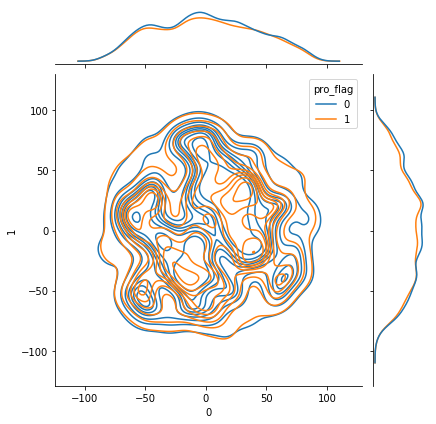

In [349]:
#let's make a plot

embedded = pd.DataFrame(X_embedded)
embedded['pro_flag'] = sample['pro_flag']

sn.jointplot(data=embedded, x=0, y=1, hue="pro_flag", kind='kde')

## That was interesting but overall the two groups look very similar; due to time constraints let's move on to modelling. (Next Notebook)